In [1]:
import numpy as np
import astropy.units as u
from astropy.constants import m_e, M_sun, h, c 
from agnpy.emission_regions import Blob
from agnpy.targets import SSDisk, SphericalShellBLR, RingDustTorus
from agnpy.compton import cos_psi
from agnpy.absorption import sigma, Absorption
import matplotlib.pyplot as plt

In [2]:
mec2 = m_e.to("erg", equivalencies=u.mass_energy())
# equivalency to transform frequencies to energies in electron rest mass units
epsilon_equivalency = [
    (u.Hz, u.Unit(""), lambda x: h.cgs * x / mec2, lambda x: x * mec2 / h.cgs)
]

In [3]:
# define the blob
spectrum_norm = 1e47 * u.erg
spectrum_dict = {"type": "PowerLaw", "parameters": {"p": 2.8, "gamma_min": 10, "gamma_max": 1e6}}
blob = Blob(
    R_b=1e16 * u.cm, 
    z=0, 
    delta_D=40, 
    Gamma=40, 
    B=0.56 * u.G, 
    spectrum_norm=spectrum_norm, 
    spectrum_dict=spectrum_dict
)

# disk parameters
M_BH = 1.2 * 1e9 * M_sun.cgs
L_disk = 2 * 1e46 * u.Unit("erg s-1")
eta = 1 / 12
R_in = 6
R_out = 200
disk = SSDisk(M_BH, L_disk, eta, R_in, R_out, R_g_units=True)

In [4]:
print(disk)

* Shakura Sunyaev accretion disk:
 - M_BH (central black hole mass): 2.39e+42 g
 - L_disk (disk luminosity): 2.00e+46 erg / s
 - eta (accretion efficiency): 8.33e-02
 - dot(m) (mass accretion rate): 2.67e+26 g / s
 - R_in (disk inner radius): 1.06e+15 cm
 - R_out (disk inner radius): 3.54e+16 cm


In [5]:
# define energy array
E = np.logspace(0, 5) * u.GeV
nu = E.to("Hz", equivalencies=u.spectral())
epsilon_1 = nu.to("", equivalencies=epsilon_equivalency) * (1 + blob.z)

In [6]:
# define array of distances 
r = 1.1e16 * u.cm # distance from BH
r_tilde = (r / disk.R_g).to_value("") 
print(r_tilde)

62.07849948671599


In [7]:
l_tilde_values = np.linspace(r_tilde, 100 * r_tilde, 10)
print(l_tilde_values)

[  62.07849949  744.94199384 1427.80548819 2110.66898255 2793.5324769
 3476.39597126 4159.25946561 4842.12295996 5524.98645432 6207.84994867]


In [8]:
def tau(epsilon):
    integrand_l = []
    for l_tilde in l_tilde_values:
        # array of m
        mu = disk.mu_from_r_tilde(l_tilde)
        phi = np.linspace(0, 2 * np.pi, 50)
        # axis 0 = phi
        # axis 1 = mu
        _phi = np.reshape(phi, (phi.size, 1))
        _mu = np.reshape(mu, (1, mu.size))
        # epsilon and phi have the same dimension of mu
        _epsilon_disk = disk.epsilon_mu(_mu, l_tilde)
        _phi_disk = disk.phi_disk_mu(_mu, l_tilde)
        _cos_psi = cos_psi(blob.mu_s, _mu, _phi)
        # compute gamma-gamma cross section
        s = _epsilon_disk * epsilon * (1 - _cos_psi) / 2
        _sigma = sigma(s).to_value("cm2")
        _integrand_denom = _epsilon_disk * np.power(l_tilde, 3) * np.power(np.power(_mu, -2) - 1, 3/2) * _mu
        _integrand = _phi_disk / _integrand_denom * (1 - _cos_psi) * _sigma
        _integral_phi = np.trapz(_integrand, phi, axis=0)
        _integral_mu = np.trapz(_integral_phi, mu, axis=0)
        integrand_l.append(_integral_mu)
    # integrate over l_tilde
    integrand_l = np.asarray(integrand_l)
    integral_l = np.trapz(integrand_l, l_tilde_values, axis=0)
    # prefactor 
    prefactor_num = 3 * disk.L_disk
    prefactor_denom = np.power(4 * np.pi, 2) * m_e * np.power(c, 3) * disk.R_g * disk.eta
    return prefactor_num / prefactor_denom * integral_l

In [9]:
taus = []
for epsilon in epsilon_1:
    taus.append(tau(epsilon).to_value("cm-2"))

/Users/cosimo/software/miniconda3/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


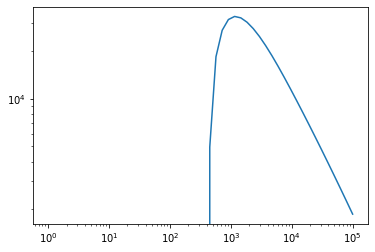

In [10]:
plt.loglog(E.to_value("GeV"), taus)